In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Load sales and calendar
sales_train = pd.read_csv('../data/raw/sales_train_validation.csv')
calendar = pd.read_csv('../data/raw/calendar.csv')
prices = pd.read_csv('../data/raw/sell_prices.csv')
segments = pd.read_csv('../data/processed/products_segmented.csv')

print(f"Products: {len(sales_train)}")
print(f"Days: {len(calendar)}")

Products: 30490
Days: 1969


In [2]:
print("TRANSFORMING TO LONG FORMAT")
print("="*60)

# Get sales columns
sales_cols = [col for col in sales_train.columns if col.startswith('d_')]

# Melt to long format (THIS WILL TAKE A FEW MINUTES!)
print("Melting data to long format...")
print("⏳ This will take 2-3 minutes for 30K products...")

sales_long = sales_train.melt(
    id_vars=['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'],
    value_vars=sales_cols,
    var_name='d',
    value_name='sales'
)

print(f"✅ Long format shape: {sales_long.shape}")
print(f"Total rows: {len(sales_long):,}")

# Merge with calendar
print("Merging with calendar...")
sales_long = sales_long.merge(calendar, on='d', how='left')
sales_long['date'] = pd.to_datetime(sales_long['date'])

print("✅ Dates added!")
print(sales_long.head())

TRANSFORMING TO LONG FORMAT
Melting data to long format...
⏳ This will take 2-3 minutes for 30K products...
✅ Long format shape: (58327370, 8)
Total rows: 58,327,370
Merging with calendar...
✅ Dates added!
                              id        item_id    dept_id   cat_id store_id  \
0  HOBBIES_1_001_CA_1_validation  HOBBIES_1_001  HOBBIES_1  HOBBIES     CA_1   
1  HOBBIES_1_002_CA_1_validation  HOBBIES_1_002  HOBBIES_1  HOBBIES     CA_1   
2  HOBBIES_1_003_CA_1_validation  HOBBIES_1_003  HOBBIES_1  HOBBIES     CA_1   
3  HOBBIES_1_004_CA_1_validation  HOBBIES_1_004  HOBBIES_1  HOBBIES     CA_1   
4  HOBBIES_1_005_CA_1_validation  HOBBIES_1_005  HOBBIES_1  HOBBIES     CA_1   

  state_id    d  sales       date  wm_yr_wk  ... wday  month  year  \
0       CA  d_1      0 2011-01-29     11101  ...    1      1  2011   
1       CA  d_1      0 2011-01-29     11101  ...    1      1  2011   
2       CA  d_1      0 2011-01-29     11101  ...    1      1  2011   
3       CA  d_1      0 2011-01-29

In [9]:
print("CREATING LAG FEATURES")
print("="*60)

# For demonstration, let's work with a SAMPLE first
# (Otherwise it will take too long!)

# Sample 100 products
sample_ids = sales_train['id'].sample(100, random_state=42).values
sales_sample = sales_long[sales_long['id'].isin(sample_ids)].copy()

print(f"Working with {len(sample_ids)} products for demonstration")
print(f"Sample size: {len(sales_sample):,} rows")

# Sort by id and date
sales_sample = sales_sample.sort_values(['id', 'date']).reset_index(drop=True)

# Create lag features
lag_days = [1, 7, 14, 28, 91]  # 1 day, 1 week, 2 weeks, 4 weeks, 1 quarter

print("\nCreating lag features...")
for lag in lag_days:
    col_name = f'sold_lag_{lag}'
    sales_sample[col_name] = sales_sample.groupby('id')['sales'].shift(lag)
    print(f"  ✅ Created: {col_name}")

print("\n✅ Lag features created!")
print(sales_sample[['id', 'date', 'sales', 'sold_lag_1', 'sold_lag_7', 'sold_lag_28']].head(30))

CREATING LAG FEATURES
Working with 100 products for demonstration
Sample size: 191,300 rows

Creating lag features...
  ✅ Created: sold_lag_1
  ✅ Created: sold_lag_7
  ✅ Created: sold_lag_14
  ✅ Created: sold_lag_28
  ✅ Created: sold_lag_91

✅ Lag features created!
                             id       date  sales  sold_lag_1  sold_lag_7  \
0   FOODS_1_049_TX_2_validation 2011-01-29      0         NaN         NaN   
1   FOODS_1_049_TX_2_validation 2011-01-30      1         0.0         NaN   
2   FOODS_1_049_TX_2_validation 2011-01-31      0         1.0         NaN   
3   FOODS_1_049_TX_2_validation 2011-02-01      0         0.0         NaN   
4   FOODS_1_049_TX_2_validation 2011-02-02      4         0.0         NaN   
5   FOODS_1_049_TX_2_validation 2011-02-03      0         4.0         NaN   
6   FOODS_1_049_TX_2_validation 2011-02-04      1         0.0         NaN   
7   FOODS_1_049_TX_2_validation 2011-02-05      2         1.0         0.0   
8   FOODS_1_049_TX_2_validation 2011-02-0

In [10]:
print("CREATING ROLLING WINDOW FEATURES")
print("="*60)

# Rolling windows
windows = [7, 14, 28, 90]

for window in windows:
    # Rolling mean
    col_mean = f'rolling_mean_{window}'
    sales_sample[col_mean] = sales_sample.groupby('id')['sales'].transform(
        lambda x: x.rolling(window=window, min_periods=1).mean()
    )
    
    # Rolling std
    col_std = f'rolling_std_{window}'
    sales_sample[col_std] = sales_sample.groupby('id')['sales'].transform(
        lambda x: x.rolling(window=window, min_periods=1).std()
    )
    
    # Rolling max
    col_max = f'rolling_max_{window}'
    sales_sample[col_max] = sales_sample.groupby('id')['sales'].transform(
        lambda x: x.rolling(window=window, min_periods=1).max()
    )
    
    print(f"  ✅ Created rolling features for window={window}")

print("\n✅ Rolling features created!")
print(sales_sample[['id', 'date', 'sales', 'rolling_mean_7', 'rolling_mean_28']].head(30))

CREATING ROLLING WINDOW FEATURES
  ✅ Created rolling features for window=7
  ✅ Created rolling features for window=14
  ✅ Created rolling features for window=28
  ✅ Created rolling features for window=90

✅ Rolling features created!
                             id       date  sales  rolling_mean_7  \
0   FOODS_1_049_TX_2_validation 2011-01-29      0        0.000000   
1   FOODS_1_049_TX_2_validation 2011-01-30      1        0.500000   
2   FOODS_1_049_TX_2_validation 2011-01-31      0        0.333333   
3   FOODS_1_049_TX_2_validation 2011-02-01      0        0.250000   
4   FOODS_1_049_TX_2_validation 2011-02-02      4        1.000000   
5   FOODS_1_049_TX_2_validation 2011-02-03      0        0.833333   
6   FOODS_1_049_TX_2_validation 2011-02-04      1        0.857143   
7   FOODS_1_049_TX_2_validation 2011-02-05      2        1.142857   
8   FOODS_1_049_TX_2_validation 2011-02-06      0        1.000000   
9   FOODS_1_049_TX_2_validation 2011-02-07      0        1.000000   
10  FOOD

In [11]:
print("CREATING CALENDAR FEATURES")
print("="*60)

# Cyclical encoding for day of week
sales_sample['dayofweek'] = sales_sample['date'].dt.dayofweek
sales_sample['day_sin'] = np.sin(2 * np.pi * sales_sample['dayofweek'] / 7)
sales_sample['day_cos'] = np.cos(2 * np.pi * sales_sample['dayofweek'] / 7)

# Month
sales_sample['month'] = sales_sample['date'].dt.month
sales_sample['month_sin'] = np.sin(2 * np.pi * sales_sample['month'] / 12)
sales_sample['month_cos'] = np.cos(2 * np.pi * sales_sample['month'] / 12)

# Is weekend
sales_sample['is_weekend'] = (sales_sample['dayofweek'] >= 5).astype(int)

# Event indicators
sales_sample['has_event'] = (~sales_sample['event_name_1'].isna()).astype(int)
sales_sample['is_sporting_event'] = (sales_sample['event_type_1'] == 'Sporting').astype(int)

# SNAP days
sales_sample['snap'] = (
    (sales_sample['snap_CA'] == 1) | 
    (sales_sample['snap_TX'] == 1) | 
    (sales_sample['snap_WI'] == 1)
).astype(int)

print("✅ Calendar features created!")
print("\nFeatures added:")
print("  - day_sin, day_cos (cyclical day of week)")
print("  - month_sin, month_cos (cyclical month)")
print("  - is_weekend")
print("  - has_event, is_sporting_event")
print("  - snap (SNAP day indicator)")

CREATING CALENDAR FEATURES
✅ Calendar features created!

Features added:
  - day_sin, day_cos (cyclical day of week)
  - month_sin, month_cos (cyclical month)
  - is_weekend
  - has_event, is_sporting_event
  - snap (SNAP day indicator)


In [12]:
print("ADDING PRICE FEATURES")
print("="*60)

# Merge prices
sales_sample = sales_sample.merge(
    prices, 
    on=['store_id', 'item_id', 'wm_yr_wk'],
    how='left'
)

# Fill missing prices
sales_sample['sell_price'] = sales_sample.groupby('item_id')['sell_price'].fillna(method='ffill')
sales_sample['sell_price'] = sales_sample.groupby('item_id')['sell_price'].fillna(method='bfill')

# Price change features
sales_sample['price_lag_1'] = sales_sample.groupby('id')['sell_price'].shift(1)
sales_sample['price_change'] = sales_sample['sell_price'] - sales_sample['price_lag_1']
sales_sample['price_change_pct'] = (sales_sample['price_change'] / sales_sample['price_lag_1']) * 100

print("✅ Price features added!")
print(sales_sample[['id', 'date', 'sales', 'sell_price', 'price_change']].head(20))

ADDING PRICE FEATURES
✅ Price features added!
                             id       date  sales  sell_price  price_change
0   FOODS_1_049_TX_2_validation 2011-01-29      0        2.18           NaN
1   FOODS_1_049_TX_2_validation 2011-01-30      1        2.18           0.0
2   FOODS_1_049_TX_2_validation 2011-01-31      0        2.18           0.0
3   FOODS_1_049_TX_2_validation 2011-02-01      0        2.18           0.0
4   FOODS_1_049_TX_2_validation 2011-02-02      4        2.18           0.0
5   FOODS_1_049_TX_2_validation 2011-02-03      0        2.18           0.0
6   FOODS_1_049_TX_2_validation 2011-02-04      1        2.18           0.0
7   FOODS_1_049_TX_2_validation 2011-02-05      2        2.18           0.0
8   FOODS_1_049_TX_2_validation 2011-02-06      0        2.18           0.0
9   FOODS_1_049_TX_2_validation 2011-02-07      0        2.18           0.0
10  FOODS_1_049_TX_2_validation 2011-02-08      1        2.18           0.0
11  FOODS_1_049_TX_2_validation 2011-02-09

VISUALIZING FEATURES


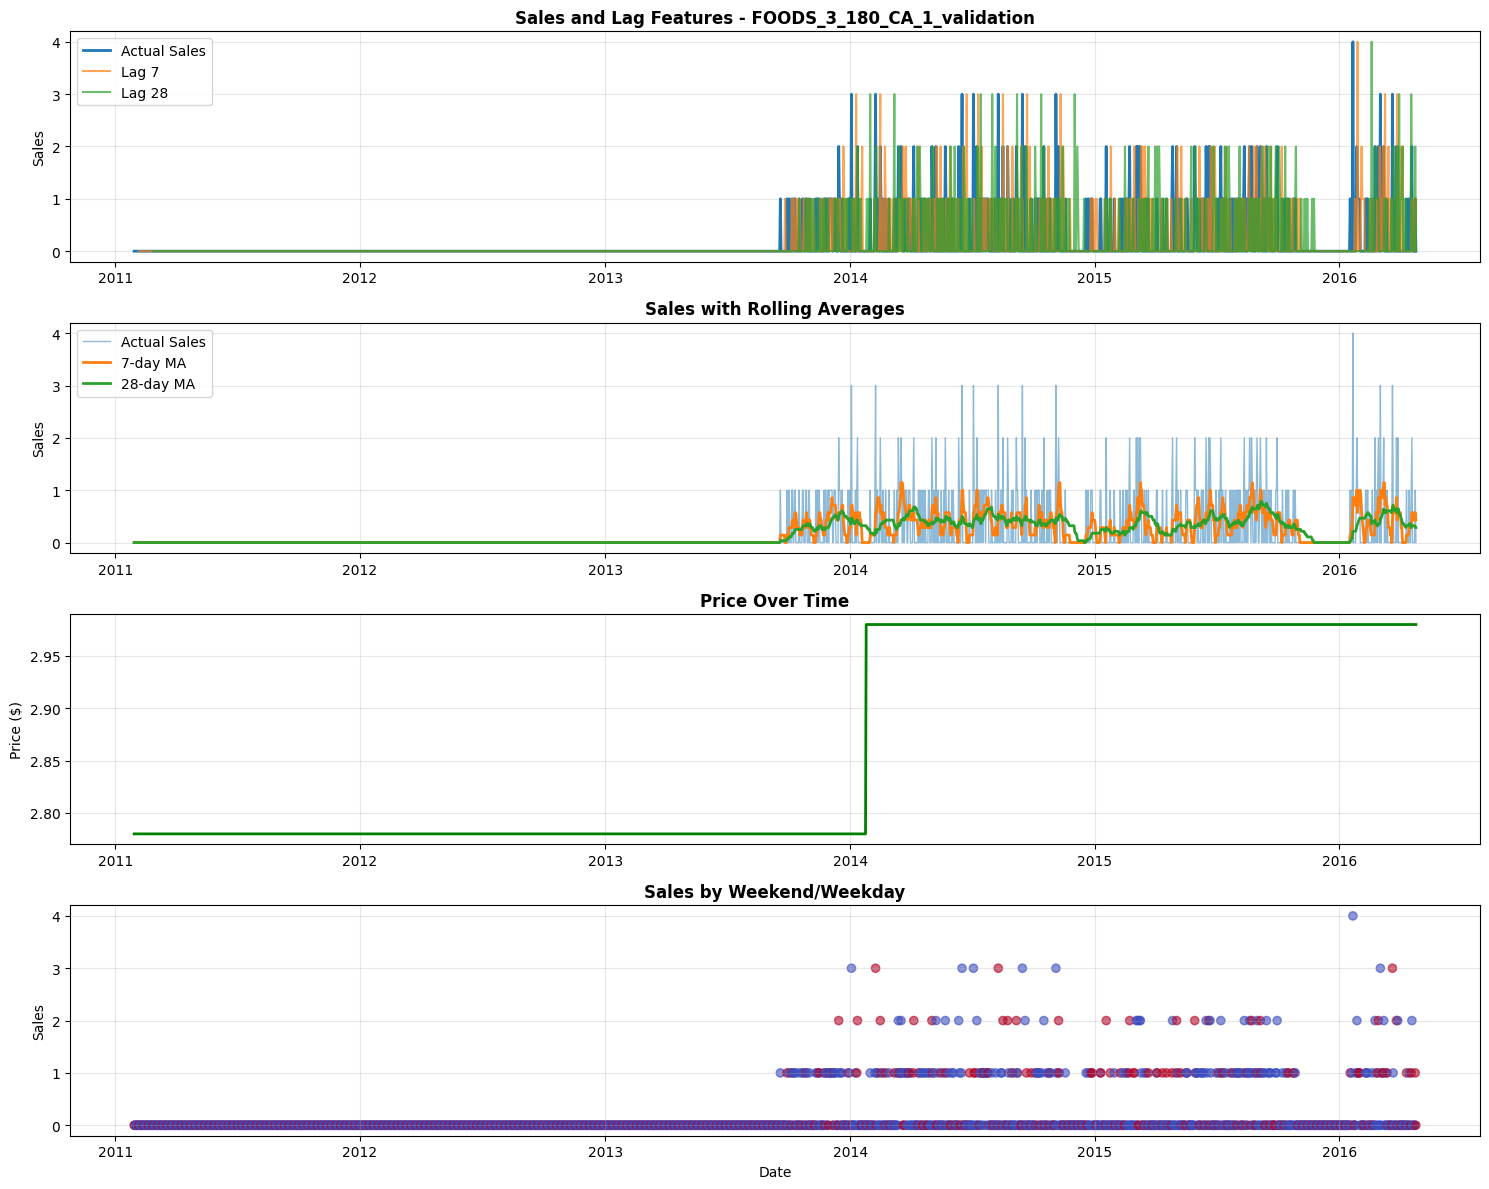

In [13]:
print("VISUALIZING FEATURES")
print("="*60)

# Pick one product
sample_product = sample_ids[0]
product_data = sales_sample[sales_sample['id'] == sample_product].copy()

fig, axes = plt.subplots(4, 1, figsize=(15, 12))

# Plot 1: Sales with lags
axes[0].plot(product_data['date'], product_data['sales'], label='Actual Sales', linewidth=2)
axes[0].plot(product_data['date'], product_data['sold_lag_7'], label='Lag 7', alpha=0.7)
axes[0].plot(product_data['date'], product_data['sold_lag_28'], label='Lag 28', alpha=0.7)
axes[0].set_title(f'Sales and Lag Features - {sample_product}', fontweight='bold')
axes[0].set_ylabel('Sales')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Rolling means
axes[1].plot(product_data['date'], product_data['sales'], label='Actual Sales', linewidth=1, alpha=0.5)
axes[1].plot(product_data['date'], product_data['rolling_mean_7'], label='7-day MA', linewidth=2)
axes[1].plot(product_data['date'], product_data['rolling_mean_28'], label='28-day MA', linewidth=2)
axes[1].set_title('Sales with Rolling Averages', fontweight='bold')
axes[1].set_ylabel('Sales')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Plot 3: Price
axes[2].plot(product_data['date'], product_data['sell_price'], color='green', linewidth=2)
axes[2].set_title('Price Over Time', fontweight='bold')
axes[2].set_ylabel('Price ($)')
axes[2].grid(True, alpha=0.3)

# Plot 4: Calendar effects
axes[3].scatter(product_data['date'], product_data['sales'], 
                c=product_data['is_weekend'], cmap='coolwarm', alpha=0.6)
axes[3].set_title('Sales by Weekend/Weekday', fontweight='bold')
axes[3].set_ylabel('Sales')
axes[3].set_xlabel('Date')
axes[3].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [14]:
print("FEATURE ENGINEERING SUMMARY")
print("="*60)

feature_groups = {
    'Lag Features': [col for col in sales_sample.columns if 'lag' in col.lower()],
    'Rolling Features': [col for col in sales_sample.columns if 'rolling' in col],
    'Calendar Features': ['day_sin', 'day_cos', 'month_sin', 'month_cos', 'is_weekend', 
                          'has_event', 'is_sporting_event', 'snap'],
    'Price Features': ['sell_price', 'price_change', 'price_change_pct']
}

total_features = 0
for group, features in feature_groups.items():
    print(f"\n{group} ({len(features)} features):")
    for feat in features:
        print(f"  - {feat}")
    total_features += len(features)

print(f"\n✅ Total features created: {total_features}")
print(f"Original columns: {len(sales_train.columns)}")
print(f"After feature engineering: {len(sales_sample.columns)}")

FEATURE ENGINEERING SUMMARY

Lag Features (6 features):
  - sold_lag_1
  - sold_lag_7
  - sold_lag_14
  - sold_lag_28
  - sold_lag_91
  - price_lag_1

Rolling Features (12 features):
  - rolling_mean_7
  - rolling_std_7
  - rolling_max_7
  - rolling_mean_14
  - rolling_std_14
  - rolling_max_14
  - rolling_mean_28
  - rolling_std_28
  - rolling_max_28
  - rolling_mean_90
  - rolling_std_90
  - rolling_max_90

Calendar Features (8 features):
  - day_sin
  - day_cos
  - month_sin
  - month_cos
  - is_weekend
  - has_event
  - is_sporting_event
  - snap

Price Features (3 features):
  - sell_price
  - price_change
  - price_change_pct

✅ Total features created: 29
Original columns: 1919
After feature engineering: 51


In [15]:
# Save the sample with features
output_path = '../data/processed/sales_with_features_sample.csv'
sales_sample.to_csv(output_path, index=False)

print(f"✅ Saved sample to: {output_path}")
print(f"Shape: {sales_sample.shape}")

✅ Saved sample to: ../data/processed/sales_with_features_sample.csv
Shape: (191300, 51)
